In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rc('font',family='malgun gothic')
plt.rc('axes',unicode_minus=False)
import seaborn as sns

# EDA
import klib

# Preprocessing&Feature Engineering
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile
from gensim.models import word2vec

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
import kerastuner as kt

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ARDRegression, BayesianRidge, Lars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from vecstack import StackingTransformer
from vecstack import stacking

# Eveluation
from sklearn.metrics import mean_squared_error # squared=False시 RMSE
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import pickle

### Read Data

In [2]:
df_train = pd.read_csv(os.path.abspath("../input")+'/X_train.csv', encoding='cp949')
y_train = pd.read_csv(os.path.abspath("../input")+'/y_train.csv', encoding='cp949').set_index('custid')
df_test = pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')
test_id = df_test['custid'].unique()
_,_,_,y_dev = train_test_split(df_train.groupby('custid').sum(), y_train, test_size=0.3, random_state=0)

In [3]:
round1_1st = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/1등feature모델링.csv'))
round1_2nd = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/2등feature모델링.csv'))
round1_my = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/averagingstk77_ridlgbmcat_dnn23.csv'))
cat_num = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/las_mix.csv'))
cy = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/averaging_rid_lgbm_cat.csv'))

In [4]:
round1_1st_dev = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/1등feature모델링_dev.csv'))
round1_2nd_dev = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/2등feature모델링_dev.csv'))
round1_my_dev = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/averagingstk77_ridlgbmcat_dnn23_dev.csv'))
cat_num_dev = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/las_mix_dev.csv'))
cy_dev = pd.read_csv(os.path.abspath(os.path.abspath("../input")+'/averaging_rid_lgbm_cat_dev.csv'))

### Ensemble

In [5]:
results_sub = pd.DataFrame({'1등':round1_1st.age,'2등':round1_2nd.age,'round1_수정':round1_my.age,'범주형,수치형분리':cat_num.age, '창용':cy.age})

In [6]:
results = pd.DataFrame({'1등':round1_1st_dev.age,'2등':round1_2nd_dev.age,'round1_수정':round1_my_dev.age,'범주형,수치형분리':cat_num_dev.age, '창용':cy_dev.age})

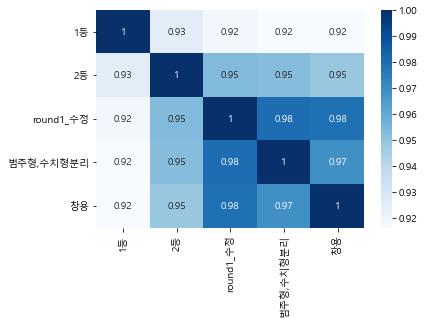

In [7]:
sns.heatmap(results.corr(), annot=True, cmap='Blues')
plt.show()

In [8]:
print(mean_squared_error(round1_1st_dev,y_dev,squared=False))
print(mean_squared_error(round1_2nd_dev,y_dev,squared=False))
print(mean_squared_error(round1_my_dev,y_dev,squared=False))
print(mean_squared_error(cat_num_dev,y_dev,squared=False))
print(mean_squared_error(cy_dev.age,y_dev,squared=False))

8.017669596193688
8.18761750214042
8.20462583336379
8.204942497555404
8.217923871088324


In [10]:
weights_avg = []
rmse_best = 1000
for i in tqdm(range(45, 101, 1)):
    for j in range(0, 101, 1):
        for k in range(0, 101, 1):
            for l in range(0,101,1):
                for m in range(0,101,1):
                    if (i+j+k+l+m) != 100:
                        continue
                    pred = (round1_1st_dev.age*i+round1_2nd_dev.age*j+round1_my_dev.age*k+cat_num_dev.age*l+cy_dev.age*m)/(i+j+k+l+m)
                    rmse = np.sqrt(mean_squared_error(y_dev, pred))
                    if rmse < rmse_best:
                        weights_avg = [i,j,k,l,m]
                        rmse_best = rmse 
                        print(rmse, i,j,k,l,m)            

print(rmse_best, weights_avg)

  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

8.022843288003866 45 0 0 0 55
8.02186571077298 45 0 0 1 54
8.020919167486026 45 0 0 2 53
8.02000366913114 45 0 0 3 52
8.019119226341012 45 0 0 4 51
8.01826584939225 45 0 0 5 50
8.0174435482048 45 0 0 6 49
8.016652332341373 45 0 0 7 48
8.015892211006884 45 0 0 8 47
8.015163193047917 45 0 0 9 46
8.014465286952225 45 0 0 10 45
8.013798500848218 45 0 0 11 44
8.013162842504508 45 0 0 12 43
8.012558319329447 45 0 0 13 42
8.011984938370702 45 0 0 14 41
8.01144270631484 45 0 0 15 40
8.010931629486947 45 0 0 16 39
8.010451713850246 45 0 0 17 38
8.010002965005764 45 0 0 18 37
8.009585388191997 45 0 0 19 36
8.00919898828461 45 0 0 20 35
8.008843769796144 45 0 0 21 34
8.008519736875762 45 0 0 22 33
8.008226893309004 45 0 0 23 32
8.007965242517564 45 0 0 24 31
8.00773478755909 45 0 0 25 30
8.007535531127008 45 0 0 26 29
8.007367475550362 45 0 0 27 28
8.007230622793683 45 0 0 28 27
8.007124974456868 45 0 0 29 26
8.007050531775088 45 0 0 30 25
8.007007295618717 45 0 0 31 24
8.00699526649328 45 0 0 32

7.998990229129784 45 12 2 23 18
7.998972730524275 45 12 2 24 17
7.9989530957197665 45 12 3 23 17
7.998951879474433 45 12 3 24 16
7.998936737129931 45 12 4 23 16
7.998854240375751 45 13 0 21 21
7.998759355165162 45 13 0 22 20
7.998695708474608 45 13 0 23 19
7.998663301049799 45 13 0 24 18
7.998662133270442 45 13 0 25 17
7.9986306061507015 45 13 1 23 18
7.998614481590358 45 13 1 24 17
7.998586279199735 45 13 2 23 17
7.998577526304304 45 13 3 22 17
7.998562727967113 45 13 3 23 16
7.998558467769561 45 13 4 22 16
7.998546684919346 45 14 0 20 21
7.99843821381406 45 14 0 21 20
7.998360982190706 45 14 0 22 19
7.998314990954227 45 14 0 23 18
7.998300240643532 45 14 0 24 17
7.9982931778759605 45 14 1 22 18
7.998263470092436 45 14 1 23 17
7.9982461497727435 45 14 2 22 17
7.998232725719975 45 14 2 23 16
7.9982198982475365 45 14 3 22 16
7.998214423504915 45 14 4 22 15
7.998163400617723 45 15 0 20 20
7.998072583473606 45 15 0 21 19
7.9980130076104725 45 15 0 22 18
7.997984673726457 45 15 0 23 17
7.9

  2%|█▍                                                                              | 1/56 [01:44<1:35:58, 104.70s/it]

7.996861618495646 46 14 0 20 20
7.996768665115438 46 14 0 21 19
7.996706958069573 46 14 0 22 18
7.996676498081395 46 14 0 23 17
7.9966513363439375 46 14 1 22 17
7.996637163298444 46 14 1 23 16
7.996616495251923 46 14 2 22 16
7.9966152815192535 46 14 3 21 16
7.996602435065153 46 14 3 22 15
7.996508574255588 46 15 0 20 19
7.996433279551016 46 15 0 21 18
7.996389232793868 46 15 0 22 17
7.996376434500521 46 15 0 23 16
7.996374956007868 46 15 1 21 17
7.996347196674619 46 15 1 22 16
7.9963374137851115 46 15 2 21 16
7.996325942109993 46 15 2 22 15
7.996320653175448 46 15 3 21 15
7.996294826814173 46 16 0 19 19
7.996205944059013 46 16 0 20 18
7.996148309913786 46 16 0 21 17
7.99612192505419 46 16 0 22 16
7.996103572522512 46 16 1 21 16
7.996093475777283 46 16 1 22 15
7.996079617296741 46 16 2 21 15
7.9960764444232515 46 16 3 21 14
7.996024955546308 46 17 0 19 18
7.9959537336301185 46 17 0 20 17
7.995913761594129 46 17 0 21 16
7.995905039907 46 17 0 22 15
7.99588261149649 46 17 1 21 15
7.995879

  4%|██▊                                                                             | 2/56 [03:25<1:32:12, 102.45s/it]

7.995419628856508 47 13 1 22 17
7.995403331813254 47 13 1 23 16
7.9953833914930525 47 13 2 22 16
7.995383384084528 47 13 2 23 15
7.995382908489008 47 13 3 21 16
7.9953679382310385 47 13 3 22 15
7.995262369492147 47 14 0 20 19
7.995184941179102 47 14 0 21 18
7.99513876566003 47 14 0 22 17
7.995123843476432 47 14 0 23 16
7.995095332011948 47 14 1 22 16
7.995086278533576 47 14 2 21 16
7.995072683161148 47 14 2 22 15
7.995068124342133 47 14 3 21 15
7.9950306001589295 47 15 0 19 19
7.994939581411435 47 15 0 20 18
7.994879816183835 47 15 0 21 17
7.994851305177035 47 15 0 22 16
7.994833680694613 47 15 1 21 16
7.99482146037682 47 15 1 22 15
7.994808330659667 47 15 2 21 15
7.994803766276714 47 15 3 21 14
7.994740575003195 47 16 0 19 18
7.994667219635133 47 16 0 20 17
7.994625119145832 47 16 0 21 16
7.994614274029066 47 16 0 22 15
7.994592572985454 47 16 1 21 15
7.994590331177814 47 16 2 20 15
7.99458081300463 47 16 2 21 14
7.994500979711891 47 17 0 19 17
7.994445289317142 47 17 0 20 16
7.994420

  5%|████▎                                                                            | 3/56 [05:01<1:27:49, 99.42s/it]

7.9940123766321936 48 13 0 21 18
7.993964072143647 48 13 0 22 17
7.993947025566346 48 13 0 23 16
7.993919240954214 48 13 1 22 16
7.9939184869750255 48 13 1 23 15
7.9939109171942695 48 13 2 21 16
7.993895197608202 48 13 2 22 15
7.993891369169875 48 13 3 21 15
7.993842143948413 48 14 0 19 19
7.993748989415379 48 14 0 20 18
7.993687093016328 48 14 0 21 17
7.9936564554773755 48 14 0 22 16
7.9936395594357545 48 14 1 21 16
7.993625215006082 48 14 1 22 15
7.993612814401732 48 14 2 21 15
7.993606858122924 48 14 3 21 14
7.993531961419248 48 15 0 19 18
7.9934564726286705 48 15 0 20 17
7.993412243419589 48 15 0 21 16
7.993399274310899 48 15 0 22 15
7.9933783010678265 48 15 1 21 15
7.993376790018889 48 15 2 20 15
7.993365148045263 48 15 2 21 14
7.993361296419905 48 16 0 18 18
7.993272214993278 48 16 0 19 17
7.993214393642036 48 16 0 20 16
7.99318783304457 48 16 0 21 15
7.993177749456337 48 16 1 20 15
7.993167482961613 48 16 1 21 14
7.993161895104617 48 16 2 20 14
7.993134323316408 48 17 0 18 17
7.

  7%|█████▊                                                                           | 4/56 [06:30<1:22:38, 95.35s/it]

7.992729491982037 49 13 0 19 19
7.992634201931493 49 13 0 20 18
7.992570174332756 49 13 0 21 17
7.99253740993715 49 13 0 22 16
7.9925359091291535 49 13 0 23 15
7.992521242707402 49 13 1 21 16
7.9925047736867745 49 13 1 22 15
7.992493102524113 49 13 2 21 15
7.99249292904522 49 13 2 22 14
7.992485754002499 49 13 3 21 14
7.992399149166991 49 14 0 19 18
7.99232152704428 49 14 0 20 17
7.992275168909566 49 14 0 21 16
7.992260075306874 49 14 0 22 15
7.992239830277575 49 14 1 21 15
7.992239050216725 49 14 2 20 15
7.992225283927696 49 14 2 21 14
7.992210465055734 49 15 0 18 18
7.9921192481154995 49 15 0 19 17
7.992059295720532 49 15 0 20 16
7.992030608574426 49 15 0 21 15
7.992021254749372 49 15 1 20 15
7.992008864053441 49 15 1 21 14
7.992004006611197 49 15 2 20 14
7.991963341067206 49 16 0 18 17
7.9918897941274505 49 16 0 19 16
7.991847512925765 49 16 0 20 15
7.991836497958389 49 16 0 21 14
7.991823066454979 49 16 1 20 14
7.991819413403741 49 16 2 20 13
7.991766667080878 49 17 0 18 16
7.99171

  9%|███████▏                                                                         | 5/56 [07:57<1:18:21, 92.19s/it]

7.991460168303179 50 12 1 22 15
7.9914492268905155 50 12 2 21 15
7.991446930524118 50 12 2 22 14
7.991440485818655 50 12 3 21 14
7.9913421704820635 50 13 0 19 18
7.991262415178666 50 13 0 20 17
7.991213927973159 50 13 0 21 16
7.991196709434706 50 13 0 22 15
7.991177193011943 50 13 1 21 15
7.991176272678985 50 13 1 22 14
7.991161253088762 50 13 2 21 14
7.991135464071088 50 14 0 18 18
7.9910421118874435 50 14 0 19 17
7.990980028422375 50 14 0 20 16
7.990949214404684 50 14 0 21 15
7.990940590635945 50 14 1 20 15
7.990926075261128 50 14 1 21 14
7.99092194848454 50 14 2 20 14
7.990868185878858 50 15 0 18 17
7.9907925058206395 50 15 0 19 16
7.990748095762409 50 15 0 20 15
7.990734956225532 50 15 0 21 14
7.990722254212682 50 15 1 20 14
7.990717208941884 50 15 2 20 13
7.990651363433041 50 16 0 18 16
7.990593357009683 50 16 0 19 15
7.990566621592181 50 16 0 20 14
7.990564813082513 50 16 1 19 14
7.990554377122634 50 16 1 20 13
7.990485000840998 50 17 0 18 15
7.9904446692272675 50 17 0 19 14
7.99

 11%|████████▋                                                                        | 6/56 [09:21<1:14:39, 89.59s/it]

7.990279167187121 51 12 0 20 17
7.990228550826412 51 12 0 21 16
7.990209206970831 51 12 0 22 15
7.990190419526852 51 12 1 21 15
7.9901873758807485 51 12 1 22 14
7.990173085824032 51 12 2 21 14
7.990136324072854 51 13 0 18 18
7.990040836977266 51 13 0 19 17
7.989976622476634 51 13 0 20 16
7.989943681324963 51 13 0 21 15
7.989942013909057 51 13 0 22 14
7.989935787885039 51 13 1 20 15
7.989919147414022 51 13 1 21 14
7.989915751533307 51 13 2 20 14
7.989915411877188 51 13 2 21 13
7.989848888931831 51 14 0 18 17
7.989771075908599 51 14 0 19 16
7.9897245368503755 51 14 0 20 15
7.989709272303658 51 14 0 21 14
7.989697300096125 51 14 1 20 14
7.989690862283008 51 14 2 20 13
7.989611914702064 51 15 0 18 16
7.989551777363619 51 15 0 19 15
7.989522915084604 51 15 0 20 14
7.9895218377906945 51 15 1 19 14
7.989509277088782 51 15 1 20 13
7.989499141629197 51 16 0 17 16
7.989425405873714 51 16 0 18 15
7.989382945497724 51 16 0 19 14
7.989371760999875 51 16 0 20 13
7.989366604980741 51 16 1 19 13
7.989

 12%|██████████▏                                                                      | 7/56 [10:39<1:09:59, 85.71s/it]

7.989115451908036 52 12 0 19 17
7.989049106467335 52 12 0 20 16
7.989014037979914 52 12 0 21 15
7.989010246857653 52 12 0 22 14
7.989006875120627 52 12 1 20 15
7.988988109196543 52 12 1 21 14
7.988985444421193 52 12 2 20 14
7.9889829812059485 52 12 2 21 13
7.988905479262169 52 13 0 18 17
7.988825533488486 52 13 0 19 16
7.988776865347591 52 13 0 20 15
7.9887594754111255 52 13 0 21 14
7.988748233303035 52 13 1 20 14
7.9887471465446955 52 13 1 21 13
7.988740402664414 52 13 2 20 13
7.988648350497699 52 14 0 18 16
7.988586082280556 52 14 0 19 15
7.988555092879216 52 14 0 20 14
7.9885547469953515 52 14 1 19 14
7.988540061135533 52 14 1 20 13
7.988517560581726 52 15 0 17 16
7.9884416921024926 52 15 0 18 15
7.988397102822497 52 15 0 19 14
7.9883837932655215 52 15 0 20 13
7.988379368165334 52 15 1 19 13
7.988343697329065 52 16 0 17 15
7.988285507993579 52 16 0 18 14
7.988258598696359 52 16 0 19 13
7.988254465313709 52 16 1 19 12
7.988220310336878 52 17 0 17 14
7.988179801131569 52 17 0 18 13
7.

 14%|███████████▌                                                                     | 8/56 [11:55<1:06:08, 82.67s/it]

7.988037983757373 53 12 0 18 17
7.987955905508934 53 12 0 19 16
7.987905108263516 53 12 0 20 15
7.9878855926178955 53 12 0 21 14
7.987875080882711 53 12 1 20 14
7.987871870190623 53 12 1 21 13
7.987865857175025 53 12 2 20 13
7.987856378798344 53 13 0 17 17
7.987760698281815 53 13 0 18 16
7.98769629928333 53 13 0 19 15
7.987663182559495 53 13 0 20 14
7.987661348499395 53 13 0 21 13
7.987646756886063 53 13 1 20 13
7.987611888549488 53 14 0 17 16
7.987533887563034 53 14 0 18 15
7.987487169298076 53 14 0 19 14
7.987471734303527 53 14 0 20 13
7.987468040338141 53 14 1 19 13
7.9874178759328744 53 15 0 17 15
7.987357555900905 53 15 0 18 14
7.987328519517987 53 15 0 19 13
7.9873229933463055 53 15 1 19 12
7.987274344626842 53 16 0 17 14
7.987231706638661 53 16 0 18 13
7.987220352951118 53 16 0 19 12
7.987181297352871 53 17 0 17 13
7.9871563421625735 53 17 0 18 12
7.987138735875323 53 18 0 17 12
7.987131463901725 53 18 0 18 11


 16%|█████████████                                                                    | 9/56 [13:08<1:02:26, 79.72s/it]

7.9871092904553045 54 11 0 20 15
7.987087648841699 54 11 0 21 14
7.987077867732174 54 11 1 20 14
7.987072532692115 54 11 1 21 13
7.987067250751541 54 11 2 20 13
7.987046797639845 54 12 0 17 17
7.986948983364494 54 12 0 18 16
7.986882453743023 54 12 0 19 15
7.986847209557227 54 12 0 20 14
7.986843251221273 54 12 0 21 13
7.986829389811901 54 12 1 20 13
7.986782151355898 54 13 0 17 16
7.986702018139896 54 13 0 18 15
7.986653170869854 54 13 0 19 14
7.986635610119814 54 13 0 20 13
7.9866326474843214 54 13 1 19 13
7.986631394248538 54 13 1 20 12
7.986567986790859 54 14 0 17 15
7.9865055361616 54 14 0 18 14
7.986474372494411 54 14 0 19 13
7.98646745327484 54 14 1 19 12
7.986404308005904 54 15 0 17 14
7.9863595411556 54 15 0 18 13
7.986346062007439 54 15 0 19 12
7.986291118105145 54 16 0 17 13
7.986264035890717 54 16 0 18 12
7.986228419235341 54 17 0 17 12
7.986219022178337 54 17 0 18 11
7.986216212585689 54 18 0 17 11


 18%|██████████████▋                                                                   | 10/56 [14:18<58:39, 76.50s/it]

7.986213228900429 55 11 0 18 16
7.9861445688753525 55 11 0 19 15
7.9861071971488835 55 11 0 20 14
7.986101114160272 55 11 0 21 13
7.986087983229298 55 11 1 20 13
7.98602837266953 55 12 0 17 16
7.985946107562805 55 12 0 18 15
7.98589513132843 55 12 0 19 14
7.985875444565584 55 12 0 20 13
7.9858732134342825 55 12 1 19 13
7.98586983573193 55 12 1 20 12
7.985794054146321 55 13 0 17 15
7.985729473079967 55 13 0 18 14
7.985696181990658 55 13 0 19 13
7.985694181269726 55 13 0 20 12
7.985687869504018 55 13 1 19 12
7.98561022529161 55 14 0 17 14
7.985563329560774 55 14 0 18 13
7.985547724635577 55 14 0 19 12
7.9855373900424995 55 15 0 16 14
7.985476889592275 55 15 0 17 13
7.985447680156742 55 15 0 18 12
7.985436863592365 55 16 0 16 13
7.985394049577637 55 16 0 17 12
7.985382527061734 55 16 0 18 11
7.985361706819219 55 17 0 17 11


 20%|████████████████                                                                  | 11/56 [15:24<55:03, 73.41s/it]

7.985350574000738 56 11 0 17 16
7.9852661774032745 56 11 0 18 15
7.985213072306231 56 11 0 19 14
7.985191259333917 56 11 0 20 13
7.985189759860282 56 11 1 19 13
7.985184257339055 56 11 1 20 12
7.985096100084858 56 12 0 17 15
7.985029388802633 56 12 0 18 14
7.9849939702141235 56 12 0 19 13
7.984989844735741 56 12 0 20 12
7.984984264280954 56 12 1 19 12
7.984972436747738 56 13 0 16 15
7.984892119144387 56 13 0 17 14
7.9848430945754965 56 13 0 18 13
7.98482536361746 56 13 0 19 12
7.984801265725246 56 14 0 16 14
7.984738635049056 56 14 0 17 13
7.984707298256177 56 14 0 18 12
7.984707255715057 56 14 0 19 11
7.984680593456517 56 15 0 16 13
7.984635650710883 56 15 0 17 12
7.984622002421163 56 15 0 18 11
7.9846104222311265 56 16 0 16 12
7.98458316808389 56 16 0 17 11
7.984581188163919 56 17 0 17 10


 21%|█████████████████▌                                                                | 12/56 [16:27<51:34, 70.34s/it]

7.984574678641522 57 10 1 20 12
7.984574280049446 57 11 0 16 16
7.984474144531226 57 11 0 17 15
7.984405303315395 57 11 0 18 14
7.9843677572114125 57 11 0 19 13
7.984361506660768 57 11 0 20 12
7.984356657692017 57 11 1 19 12
7.984332458883889 57 12 0 16 15
7.984250010064308 57 12 0 17 14
7.984198856760758 57 12 0 18 13
7.984178999574754 57 12 0 19 12
7.9841411362296055 57 13 0 16 14
7.984076375550485 57 13 0 17 13
7.9840429113248 57 13 0 18 12
7.984040743946078 57 13 0 19 11
7.984000315716923 57 14 0 16 13
7.9839532442845655 57 14 0 17 12
7.983937469966746 57 14 0 18 11
7.983910000018116 57 15 0 16 12
7.983880618603206 57 15 0 17 11
7.983870190847157 57 16 0 16 11
7.983858499884691 57 16 0 17 10


 23%|███████████████████                                                               | 13/56 [17:30<48:47, 68.08s/it]

7.98385723444037 58 10 0 18 14
7.98381756086548 58 10 0 19 13
7.983809184988396 58 10 0 20 12
7.983805067659957 58 10 1 19 12
7.983768495960924 58 11 0 16 15
7.983683916388175 58 11 0 17 14
7.983630634514296 58 11 0 18 13
7.9836086509659205 58 11 0 19 12
7.9835570204067325 58 12 0 16 14
7.983490130008756 58 12 0 17 13
7.983454538335624 58 12 0 18 12
7.983450245805941 58 12 0 19 11
7.983396049799877 58 13 0 16 13
7.983346849785898 58 13 0 17 12
7.983328949246387 58 13 0 18 11
7.983285587195423 58 14 0 16 12
7.9832540784389945 58 14 0 17 11
7.98325386963025 58 14 0 18 10
7.9832256346899815 58 15 0 16 11
7.983211817728907 58 15 0 17 10


 25%|████████████████████▌                                                             | 14/56 [18:30<45:52, 65.54s/it]

7.983193854286899 59 10 0 17 14
7.983138444067975 59 10 0 18 13
7.983114334083585 59 10 0 19 12
7.983114057073597 59 10 1 19 11
7.983048934942276 59 11 0 16 14
7.9829799151705645 59 11 0 17 13
7.982942196096192 59 11 0 18 12
7.982935778162843 59 11 0 19 11
7.982867812966603 59 12 0 16 13
7.982816484537044 59 12 0 17 12
7.9827964576429835 59 12 0 18 11
7.982737201599501 59 13 0 16 12
7.982703565488531 59 13 0 17 11
7.982701231474773 59 13 0 18 10
7.982657103320312 59 14 0 16 11
7.982641160168574 59 14 0 17 10
7.982627519649597 59 15 0 16 10


 27%|█████████████████████▉                                                            | 15/56 [19:28<43:12, 63.24s/it]

7.9826168943540035 60 10 0 16 14
7.982545745614716 60 10 0 17 13
7.982505899246182 60 10 0 18 12
7.982497355717157 60 10 0 19 11
7.982415620310789 60 11 0 16 13
7.982362163692641 60 11 0 17 12
7.982340010371952 60 11 0 18 11
7.982331925844273 60 12 0 15 13
7.982264858899673 60 12 0 16 12
7.982229095481997 60 12 0 17 11
7.982224636012 60 12 0 18 10
7.982213986565278 60 13 0 15 12
7.982164612982795 60 13 0 16 11
7.982146543509084 60 13 0 17 10
7.982114884463399 60 14 0 16 10
7.982114509341239 60 14 0 17 9


 29%|███████████████████████▍                                                          | 16/56 [20:19<39:42, 59.56s/it]

7.982039484756431 61 10 0 16 13
7.981983900237641 61 10 0 17 12
7.981959620479044 61 10 0 18 11
7.981937768264689 61 11 0 15 13
7.981868572595904 61 11 0 16 12
7.9818306819802265 61 11 0 17 11
7.9818240968634795 61 11 0 18 10
7.9817996793427755 61 12 0 15 12
7.981748177753095 61 12 0 16 11
7.9817279818868885 61 12 0 17 10
7.981712109237578 61 13 0 15 11
7.981678302513999 61 13 0 16 10
7.981675801907678 61 13 0 17 9
7.9816750596118835 61 14 0 15 10
7.981658948205434 61 14 0 16 9


 30%|████████████████████████▉                                                         | 17/56 [21:05<36:09, 55.62s/it]

7.981655298838493 62 9 0 18 11
7.981619677940898 62 10 0 15 13
7.981548354016864 62 10 0 16 12
7.981508336372772 62 10 0 17 11
7.981499625479516 62 10 0 18 10
7.981461438843143 62 11 0 15 12
7.981407809535892 62 11 0 16 11
7.981385487267471 62 11 0 17 10
7.981353720082448 62 12 0 15 11
7.981317786281846 62 12 0 16 10
7.981313160002355 62 12 0 17 9
7.981296523704343 62 13 0 15 10
7.981278285964259 62 13 0 16 9


 32%|██████████████████████████▎                                                       | 18/56 [21:54<33:50, 53.43s/it]

7.981262067876281 63 9 0 17 11
7.9812512311375325 63 9 0 18 10
7.981199274737427 63 10 0 15 12
7.981143518063168 63 10 0 16 11
7.981119069443649 63 10 0 17 10
7.981071406781401 63 11 0 15 11
7.981033346074972 63 11 0 16 10
7.981026593994065 63 11 0 17 9
7.980994062527881 63 12 0 15 10
7.980973698446001 63 12 0 16 9
7.980967243445755 63 13 0 15 9
7.98096457630907 63 13 0 16 8


 34%|███████████████████████████▊                                                      | 19/56 [22:42<32:03, 51.99s/it]

7.980955310892831 64 9 0 16 11
7.980928736034159 64 9 0 17 10
7.980865177407704 64 10 0 15 11
7.980824990027532 64 10 0 16 10
7.9808161120777505 64 10 0 17 9
7.980767684731906 64 11 0 15 10
7.980745194360904 64 11 0 16 9
7.980720718346837 64 12 0 15 9
7.980715925408482 64 12 0 16 8


 36%|█████████████████████████████▎                                                    | 20/56 [23:25<29:36, 49.34s/it]

7.980692724098629 65 9 0 16 10
7.980681720273319 65 9 0 17 9
7.980673323454585 65 10 0 14 11
7.980617396790954 65 10 0 15 10
7.9805927802443355 65 10 0 16 9
7.980588511874612 65 11 0 14 10
7.980550282548962 65 11 0 15 9
7.980543363743002 65 11 0 16 8
7.98053369640837 65 12 0 15 8


 38%|██████████████████████████████▊                                                   | 21/56 [24:08<27:41, 47.47s/it]

7.980516460455862 66 9 0 16 9
7.980496296483098 66 10 0 14 10
7.98045594092717 66 10 0 15 9
7.980446896248475 66 10 0 16 8
7.980441864895298 66 11 0 14 9
7.9804192072871345 66 11 0 15 8


 39%|████████████████████████████████▏                                                 | 22/56 [24:50<25:55, 45.75s/it]

7.980405598575492 67 10 0 14 9
7.980380815055816 67 10 0 15 8
7.980374463200102 67 11 0 15 7


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [39:43<00:00, 42.56s/it]

7.980374463200102 [67, 11, 0, 15, 7]


### Modeling

#### Model Tuning

In [11]:
results = np.array(results)
y_dev = np.array(y_dev)

In [12]:
r_train, r_dev, y_train2, y_dev2 = train_test_split(results,y_dev,test_size=0.3,random_state=0)

In [13]:
pbounds = {
    'alpha':(0,50)
}
def rid_opt(alpha):
    params = {
        'alpha':alpha
    }
    rid = Ridge(random_state=0, **params)
    rid.fit(r_train,y_train2)
    score = mean_squared_error(rid.predict(r_dev),y_dev2,squared=False)
    return -score
BO_rid = BayesianOptimization(rid_opt, pbounds, random_state=0)
BO_rid.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -7.852    |  27.44    |
|  2        | -7.852    |  35.76    |
|  3        | -7.852    |  30.14    |
|  4        | -7.852    |  27.24    |
|  5        | -7.852    |  21.18    |
|  6        | -7.852    |  32.29    |
|  7        | -7.852    |  21.88    |
|  8        | -7.852    |  44.59    |
|  9        | -7.852    |  48.18    |
|  10       | -7.852    |  19.17    |
|  11       | -7.852    |  39.59    |
|  12       | -7.852    |  26.44    |
|  13       | -7.852    |  28.4     |
|  14       | -7.852    |  46.28    |
|  15       | -7.852    |  3.552    |
|  16       | -7.852    |  4.356    |
|  17       | -7.852    |  1.011    |
|  18       | -7.852    |  41.63    |
|  19       | -7.852    |  38.91    |
|  20       | -7.852    |  43.5     |
|  21       | -7.852    |  48.93    |
|  22       | -7.852    |  39.96    |
|  23       | -7.852    |  23.07    |
|  24       | -7.852    |  39.03    |
|  25       

In [14]:
pbounds = {
    'alpha':(0,50)
}
def las_opt(alpha):
    params = {
        'alpha':alpha
    }
    las = Lasso(random_state=0, **params)
    las.fit(r_train,y_train2)
    score = mean_squared_error(las.predict(r_dev),y_dev2,squared=False)
    return -score
BO_las = BayesianOptimization(las_opt, pbounds, random_state=0)
BO_las.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -8.842    |  27.44    |
|  2        | -9.474    |  35.76    |
|  3        | -9.032    |  30.14    |
|  4        | -8.828    |  27.24    |
|  5        | -8.461    |  21.18    |
|  6        | -9.194    |  32.29    |
|  7        | -8.499    |  21.88    |
|  8        | -10.22    |  44.59    |
|  9        | -10.22    |  48.18    |
|  10       | -8.359    |  19.17    |
|  11       | -9.806    |  39.59    |
|  12       | -8.775    |  26.44    |
|  13       | -8.908    |  28.4     |
|  14       | -10.22    |  46.28    |
|  15       | -7.87     |  3.552    |
|  16       | -7.878    |  4.356    |
|  17       | -7.853    |  1.011    |
|  18       | -9.994    |  41.63    |
|  19       | -9.746    |  38.91    |
|  20       | -10.17    |  43.5     |
|  21       | -10.22    |  48.93    |
|  22       | -9.84     |  39.96    |
|  23       | -8.567    |  23.07    |
|  24       | -9.756    |  39.03    |
|  25       

In [15]:
pbounds = {
    'alpha':(0,50)
}
def ela_opt(alpha):
    params = {
        'alpha':alpha
    }
    ela = ElasticNet(random_state=0, **params)
    ela.fit(r_train,y_train2)
    score = mean_squared_error(ela.predict(r_dev),y_dev2,squared=False)
    return -score
BO_ela = BayesianOptimization(ela_opt, pbounds, random_state=0)
BO_ela.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -8.191    |  27.44    |
|  2        | -8.428    |  35.76    |
|  3        | -8.263    |  30.14    |
|  4        | -8.186    |  27.24    |
|  5        | -8.044    |  21.18    |
|  6        | -8.324    |  32.29    |
|  7        | -8.059    |  21.88    |
|  8        | -8.72     |  44.59    |
|  9        | -8.848    |  48.18    |
|  10       | -8.004    |  19.17    |
|  11       | -8.55     |  39.59    |
|  12       | -8.166    |  26.44    |
|  13       | -8.217    |  28.4     |
|  14       | -8.779    |  46.28    |
|  15       | -7.831    |  3.552    |
|  16       | -7.831    |  4.356    |
|  17       | -7.841    |  1.011    |
|  18       | -8.618    |  41.63    |
|  19       | -8.528    |  38.91    |
|  20       | -8.682    |  43.5     |
|  21       | -8.875    |  48.93    |
|  22       | -8.562    |  39.96    |
|  23       | -8.086    |  23.07    |
|  24       | -8.532    |  39.03    |
|  25       

In [16]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def ard_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    ard = ARDRegression(**params)
    ard.fit(r_train,y_train2)
    score = mean_squared_error(ard.predict(r_dev),y_dev2,squared=False)
    return -score
BO_ard = BayesianOptimization(ard_opt, pbounds, random_state=0)
BO_ard.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -7.852    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -7.852    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -7.852    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -7.852    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -7.852    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -7.852    |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -7.852    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -7.852    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -7.849    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -7.852    |  33.53    |  10.52    |  1.2

|  60       | -7.851    |  14.63    |  12.44    |  4.98     |  1.253    |  286.8    |
|  61       | -7.85     |  11.39    |  10.82    |  7.056    |  0.7653   |  284.6    |
|  62       | -7.851    |  17.91    |  20.78    |  6.804    |  1.996    |  699.1    |
|  63       | -7.852    |  11.94    |  10.18    |  0.8703   |  0.8418   |  286.1    |
|  64       | -7.852    |  23.4     |  22.25    |  3.161    |  2.881    |  702.8    |
|  65       | -7.851    |  11.73    |  6.149    |  4.135    |  1.412    |  289.6    |
|  66       | -7.85     |  15.79    |  10.69    |  7.804    |  1.3      |  287.0    |
|  67       | -7.852    |  16.93    |  11.2     |  4.433    |  3.007    |  291.1    |
|  68       | -7.851    |  20.41    |  24.49    |  2.1      |  0.409    |  701.7    |
|  69       | -7.852    |  8.444    |  10.78    |  3.47     |  3.086    |  287.5    |
|  70       | -7.848    |  21.86    |  19.94    |  5.922    |  0.2949   |  698.4    |
|  71       | -7.851    |  18.16    |  21.21    |  5.4

In [17]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def bay_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    bay = BayesianRidge(**params)
    bay.fit(r_train,y_train2)
    score = mean_squared_error(bay.predict(r_dev),y_dev2,squared=False)
    return -score
BO_bay = BayesianOptimization(bay_opt, pbounds, random_state=0)
BO_bay.maximize(init_points=50, n_iter=50)

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -7.852    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -7.852    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -7.852    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -7.852    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -7.852    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -7.851    |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -7.852    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -7.852    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -7.848    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -7.852    |  33.53    |  10.52    |  1.2

|  61       | -7.849    |  11.39    |  10.82    |  7.056    |  0.7653   |  284.6    |
|  62       | -7.851    |  17.91    |  20.78    |  6.804    |  1.996    |  699.1    |
|  63       | -7.851    |  11.94    |  10.18    |  0.8703   |  0.8418   |  286.1    |
|  64       | -7.851    |  26.54    |  20.77    |  8.185    |  2.506    |  284.4    |
|  65       | -7.851    |  11.85    |  5.208    |  5.348    |  2.839    |  284.6    |
|  66       | -7.851    |  11.74    |  6.339    |  5.428    |  2.523    |  281.0    |
|  67       | -7.849    |  9.237    |  8.594    |  3.361    |  0.4312   |  279.6    |
|  68       | -7.851    |  17.48    |  13.9     |  0.976    |  1.124    |  288.6    |
|  69       | -7.85     |  11.91    |  11.22    |  4.361    |  0.9949   |  295.2    |
|  70       | -7.85     |  5.738    |  5.905    |  1.023    |  0.3539   |  279.7    |
|  71       | -7.851    |  18.16    |  21.21    |  5.488    |  2.554    |  701.5    |
|  72       | -7.851    |  25.13    |  2.85     |  0.8

In [18]:
pbounds = {
    'n_estimators':(100,1000),
    'learning_rate':(0.00000000000000000000000000000000000000000000000001,1),
    'max_depth':(2, 32),
    'num_leaves':(2, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}
def lgbm_opt(n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
             subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":learning_rate,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha
    }
    lgbm = LGBMRegressor(random_state=0, **params)
    lgbm.fit(r_train,y_train2)
    score = mean_squared_error(lgbm.predict(r_dev),y_dev2,squared=False)
    return -score
BO_lgbm = BayesianOptimization(lgbm_opt, pbounds, random_state=0)
BO_lgbm.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -8.593    |  0.7744   |  0.7152   |  305.4    |  18.35    |  90.49    |  32.65    |  493.8    |  57.29    |  48.18    |  3.835    |  0.8959   |
|  2        | -8.533    |  0.7644   |  0.568    |  463.5    |  4.131    |  26.55    |  1.991    |  849.4    |  50.25    |  43.5     |  9.786    |  0.8996   |
|  3        | -9.391    |  0.7307   |  0.7805   |  67.95    |  21.2     |  37.24    |  47.29    |  569.7    |  27.71    |  13.24    |  7.743    |  0.7281   |
|  4        | -8.036    |  0.7842   |  0.01879  |  312.6    |  20.36    |  127.2    |  47.24    |  713.6    |  24.29    |  21.86    |  6.977    |  0.5301   |
|  5        | -8.564    |  0.8334   |  0.6706   |  1

|  31       | -8.745    |  0.5906   |  0.7885   |  37.86    |  22.91    |  158.0    |  39.09    |  333.5    |  25.18    |  29.38    |  2.729    |  0.6854   |
|  32       | -8.553    |  0.5985   |  0.4599   |  31.86    |  25.99    |  24.62    |  26.42    |  376.1    |  37.81    |  47.97    |  6.456    |  0.5177   |
|  33       | -9.4      |  0.7152   |  0.51     |  272.7    |  22.44    |  62.74    |  7.314    |  453.4    |  61.3     |  9.365    |  9.04     |  0.7719   |
|  34       | -9.44     |  0.7285   |  0.882    |  234.7    |  23.73    |  85.81    |  45.3     |  721.0    |  45.38    |  16.39    |  7.568    |  0.818    |
|  35       | -8.302    |  0.62     |  0.1605   |  400.2    |  30.77    |  97.05    |  29.96    |  872.0    |  30.35    |  47.59    |  5.758    |  0.9104   |
|  36       | -8.786    |  0.9544   |  0.8155   |  88.11    |  20.87    |  85.7     |  4.073    |  481.6    |  18.04    |  42.45    |  0.334    |  0.9795   |
|  37       | -8.377    |  0.6777   |  0.3567   |  1

|  63       | -9.17     |  0.5527   |  0.971    |  318.2    |  21.83    |  131.1    |  38.58    |  708.9    |  9.903    |  7.825    |  9.825    |  0.7519   |
|  64       | -8.731    |  0.5263   |  0.5921   |  173.9    |  25.18    |  52.6     |  11.69    |  132.0    |  28.11    |  20.83    |  9.741    |  0.6726   |
|  65       | -9.017    |  0.6962   |  0.5244   |  144.4    |  22.82    |  24.55    |  25.31    |  765.2    |  44.55    |  24.18    |  5.851    |  0.5296   |
|  66       | -8.03     |  0.8035   |  0.2129   |  177.0    |  17.24    |  40.27    |  36.61    |  153.8    |  5.445    |  8.454    |  9.276    |  0.6828   |
|  67       | -7.985    |  0.8691   |  0.076    |  178.7    |  22.49    |  47.53    |  25.1     |  154.3    |  15.37    |  11.17    |  5.952    |  0.7085   |
|  68       | -8.224    |  0.6773   |  0.2712   |  38.97    |  10.57    |  131.4    |  7.819    |  288.2    |  13.94    |  29.63    |  9.091    |  0.5968   |
|  69       | -7.95     |  0.954    |  0.8302   |  3

|  95       | -8.598    |  0.7898   |  0.5267   |  184.0    |  10.41    |  43.17    |  29.03    |  157.6    |  17.8     |  27.32    |  7.531    |  0.9526   |
|  96       | -8.166    |  0.7486   |  0.348    |  36.29    |  3.335    |  134.1    |  16.79    |  292.7    |  6.86     |  12.99    |  5.042    |  0.8879   |
|  97       | -8.517    |  0.7086   |  0.5778   |  489.4    |  16.92    |  84.19    |  2.388    |  675.7    |  44.97    |  48.15    |  7.521    |  0.8431   |
|  98       | -8.587    |  0.6166   |  0.4523   |  24.02    |  5.59     |  93.81    |  8.643    |  325.7    |  27.52    |  18.51    |  0.3086   |  0.5183   |
|  99       | -8.801    |  0.6984   |  0.6325   |  419.0    |  9.997    |  187.6    |  27.5     |  982.0    |  48.23    |  25.89    |  2.976    |  0.7618   |
|  100      | -7.954    |  0.6223   |  0.02344  |  221.7    |  28.43    |  134.3    |  4.981    |  903.4    |  6.976    |  43.72    |  2.593    |  0.551    |


In [19]:
max_params_rid = BO_rid.max['params']
max_params_las = BO_las.max['params']
max_params_ela = BO_ela.max['params']
max_params_ard = BO_ard.max['params']
max_params_bay = BO_bay.max['params']
max_params_lgbm = BO_lgbm.max['params']

In [20]:
max_params_ard['n_iter'] = int(round(max_params_ard['n_iter']))

max_params_bay['n_iter'] = int(round(max_params_bay['n_iter']))

max_params_lgbm['num_leaves'] = int(round(max_params_lgbm['num_leaves']))
max_params_lgbm['n_estimators'] = int(round(max_params_lgbm['n_estimators']))
max_params_lgbm['max_depth'] = int(round(max_params_lgbm['max_depth']))
max_params_lgbm['min_child_samples'] = int(round(max_params_lgbm['min_child_samples']))
max_params_lgbm['min_child_weight'] = int(round(max_params_lgbm['min_child_weight']))
max_params_lgbm['max_bin'] = int(round(max_params_lgbm['max_bin']))
max_params_lgbm['subsample'] = max(min(max_params_lgbm['subsample'], 1), 0)
max_params_lgbm['colsample_bytree'] = max(min(max_params_lgbm['colsample_bytree'], 1), 0)

In [21]:
print(max_params_rid,'\n',max_params_las,'\n',max_params_ela,'\n',max_params_ard,'\n',max_params_bay,'\n',max_params_lgbm)

{'alpha': 49.999950601569495} 
 {'alpha': 0.26188301605808983} 
 {'alpha': 3.7448811549985694} 
 {'alpha_1': 13.176554476491098, 'alpha_2': 8.996436200286867, 'lambda_1': 9.554226141511812, 'lambda_2': 0.16251937305357345, 'n_iter': 280} 
 {'alpha_1': 13.397867547347476, 'alpha_2': 25.18224143002935, 'lambda_1': 8.036104554365131, 'lambda_2': 0.09122351938384954, 'n_iter': 697} 
 {'colsample_bytree': 0.8698521040153242, 'learning_rate': 0.044341180668791336, 'max_bin': 177, 'max_depth': 24, 'min_child_samples': 80, 'min_child_weight': 9, 'n_estimators': 144, 'num_leaves': 13, 'reg_alpha': 4.384760925968563, 'reg_lambda': 6.900108209404186, 'subsample': 0.6131809100527758}


In [22]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

regs_trained = [(name, reg.fit(r_train,y_train2), float(mean_squared_error(reg.predict(r_dev),y_dev2,squared=False))) 
                    for name, reg in tqdm(regs_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:00<00:00, 47.58it/s]

Learning rate set to 0.051078
0:	learn: 10.3239239	total: 172ms	remaining: 2m 51s
1:	learn: 10.1389424	total: 175ms	remaining: 1m 27s
2:	learn: 9.9570713	total: 178ms	remaining: 59.1s
3:	learn: 9.7981839	total: 180ms	remaining: 44.9s
4:	learn: 9.6491852	total: 183ms	remaining: 36.4s
5:	learn: 9.5157511	total: 186ms	remaining: 30.8s
6:	learn: 9.3871912	total: 188ms	remaining: 26.7s
7:	learn: 9.2659255	total: 191ms	remaining: 23.7s
8:	learn: 9.1570667	total: 195ms	remaining: 21.4s
9:	learn: 9.0559244	total: 197ms	remaining: 19.5s
10:	learn: 8.9654908	total: 200ms	remaining: 18s
11:	learn: 8.8798472	total: 202ms	remaining: 16.6s
12:	learn: 8.7977478	total: 204ms	remaining: 15.5s
13:	learn: 8.7308606	total: 207ms	remaining: 14.6s
14:	learn: 8.6648555	total: 210ms	remaining: 13.8s
15:	learn: 8.6058643	total: 212ms	remaining: 13s
16:	learn: 8.5494111	total: 214ms	remaining: 12.4s
17:	learn: 8.4985708	total: 217ms	remaining: 11.8s
18:	learn: 8.4519364	total: 219ms	remaining: 11.3s
19:	learn: 

224:	learn: 7.5739561	total: 692ms	remaining: 2.38s
225:	learn: 7.5729300	total: 694ms	remaining: 2.38s
226:	learn: 7.5704867	total: 697ms	remaining: 2.37s
227:	learn: 7.5659180	total: 699ms	remaining: 2.37s
228:	learn: 7.5649739	total: 701ms	remaining: 2.36s
229:	learn: 7.5639398	total: 703ms	remaining: 2.35s
230:	learn: 7.5626640	total: 706ms	remaining: 2.35s
231:	learn: 7.5610508	total: 709ms	remaining: 2.35s
232:	learn: 7.5593278	total: 711ms	remaining: 2.34s
233:	learn: 7.5566066	total: 713ms	remaining: 2.33s
234:	learn: 7.5520396	total: 716ms	remaining: 2.33s
235:	learn: 7.5504671	total: 718ms	remaining: 2.32s
236:	learn: 7.5469028	total: 720ms	remaining: 2.32s
237:	learn: 7.5438454	total: 722ms	remaining: 2.31s
238:	learn: 7.5405141	total: 725ms	remaining: 2.31s
239:	learn: 7.5379344	total: 727ms	remaining: 2.3s
240:	learn: 7.5368304	total: 729ms	remaining: 2.29s
241:	learn: 7.5345725	total: 731ms	remaining: 2.29s
242:	learn: 7.5333096	total: 733ms	remaining: 2.28s
243:	learn: 7

451:	learn: 7.0860647	total: 1.21s	remaining: 1.47s
452:	learn: 7.0820555	total: 1.21s	remaining: 1.46s
453:	learn: 7.0786016	total: 1.21s	remaining: 1.46s
454:	learn: 7.0772392	total: 1.22s	remaining: 1.46s
455:	learn: 7.0753661	total: 1.22s	remaining: 1.45s
456:	learn: 7.0724101	total: 1.22s	remaining: 1.45s
457:	learn: 7.0708699	total: 1.22s	remaining: 1.45s
458:	learn: 7.0681637	total: 1.23s	remaining: 1.44s
459:	learn: 7.0667784	total: 1.23s	remaining: 1.44s
460:	learn: 7.0626496	total: 1.23s	remaining: 1.44s
461:	learn: 7.0613358	total: 1.23s	remaining: 1.44s
462:	learn: 7.0589706	total: 1.23s	remaining: 1.43s
463:	learn: 7.0582921	total: 1.24s	remaining: 1.43s
464:	learn: 7.0546117	total: 1.24s	remaining: 1.43s
465:	learn: 7.0507350	total: 1.24s	remaining: 1.42s
466:	learn: 7.0474810	total: 1.24s	remaining: 1.42s
467:	learn: 7.0441751	total: 1.25s	remaining: 1.42s
468:	learn: 7.0401190	total: 1.25s	remaining: 1.41s
469:	learn: 7.0361219	total: 1.25s	remaining: 1.41s
470:	learn: 

680:	learn: 6.6455048	total: 1.73s	remaining: 809ms
681:	learn: 6.6418934	total: 1.73s	remaining: 807ms
682:	learn: 6.6375687	total: 1.73s	remaining: 805ms
683:	learn: 6.6366442	total: 1.74s	remaining: 802ms
684:	learn: 6.6346436	total: 1.74s	remaining: 800ms
685:	learn: 6.6339689	total: 1.74s	remaining: 797ms
686:	learn: 6.6331980	total: 1.74s	remaining: 795ms
687:	learn: 6.6312579	total: 1.75s	remaining: 792ms
688:	learn: 6.6282983	total: 1.75s	remaining: 790ms
689:	learn: 6.6260022	total: 1.75s	remaining: 787ms
690:	learn: 6.6251559	total: 1.75s	remaining: 784ms
691:	learn: 6.6219383	total: 1.76s	remaining: 782ms
692:	learn: 6.6209532	total: 1.76s	remaining: 779ms
693:	learn: 6.6189018	total: 1.76s	remaining: 777ms
694:	learn: 6.6182905	total: 1.76s	remaining: 774ms
695:	learn: 6.6167071	total: 1.77s	remaining: 772ms
696:	learn: 6.6125814	total: 1.77s	remaining: 769ms
697:	learn: 6.6116513	total: 1.77s	remaining: 766ms
698:	learn: 6.6096384	total: 1.77s	remaining: 764ms
699:	learn: 

905:	learn: 6.2562964	total: 2.24s	remaining: 233ms
906:	learn: 6.2538592	total: 2.25s	remaining: 230ms
907:	learn: 6.2527756	total: 2.25s	remaining: 228ms
908:	learn: 6.2525279	total: 2.25s	remaining: 225ms
909:	learn: 6.2493331	total: 2.25s	remaining: 223ms
910:	learn: 6.2480137	total: 2.26s	remaining: 220ms
911:	learn: 6.2471749	total: 2.26s	remaining: 218ms
912:	learn: 6.2467338	total: 2.26s	remaining: 215ms
913:	learn: 6.2444173	total: 2.26s	remaining: 213ms
914:	learn: 6.2414313	total: 2.27s	remaining: 210ms
915:	learn: 6.2410981	total: 2.27s	remaining: 208ms
916:	learn: 6.2406587	total: 2.27s	remaining: 206ms
917:	learn: 6.2401144	total: 2.27s	remaining: 203ms
918:	learn: 6.2383641	total: 2.27s	remaining: 201ms
919:	learn: 6.2370516	total: 2.28s	remaining: 198ms
920:	learn: 6.2364369	total: 2.28s	remaining: 196ms
921:	learn: 6.2361037	total: 2.28s	remaining: 193ms
922:	learn: 6.2345501	total: 2.28s	remaining: 191ms
923:	learn: 6.2316830	total: 2.29s	remaining: 188ms
924:	learn: 

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.38it/s]

983:	learn: 6.1404345	total: 2.42s	remaining: 39.3ms
984:	learn: 6.1400866	total: 2.42s	remaining: 36.9ms
985:	learn: 6.1397930	total: 2.42s	remaining: 34.4ms
986:	learn: 6.1383501	total: 2.42s	remaining: 31.9ms
987:	learn: 6.1358989	total: 2.43s	remaining: 29.5ms
988:	learn: 6.1352119	total: 2.43s	remaining: 27ms
989:	learn: 6.1343933	total: 2.43s	remaining: 24.6ms
990:	learn: 6.1324682	total: 2.43s	remaining: 22.1ms
991:	learn: 6.1313039	total: 2.44s	remaining: 19.6ms
992:	learn: 6.1284505	total: 2.44s	remaining: 17.2ms
993:	learn: 6.1271808	total: 2.44s	remaining: 14.7ms
994:	learn: 6.1259871	total: 2.44s	remaining: 12.3ms
995:	learn: 6.1255373	total: 2.44s	remaining: 9.82ms
996:	learn: 6.1244329	total: 2.45s	remaining: 7.37ms
997:	learn: 6.1217039	total: 2.45s	remaining: 4.91ms
998:	learn: 6.1205018	total: 2.45s	remaining: 2.45ms
999:	learn: 6.1191231	total: 2.45s	remaining: 0us


In [23]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

regs_trained_for_submissions = [(name, reg.fit(results,y_dev)) for name, reg in tqdm(regs_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:00<00:00, 41.78it/s]

Learning rate set to 0.054428
0:	learn: 10.2248393	total: 3.06ms	remaining: 3.06s
1:	learn: 10.0298718	total: 5.72ms	remaining: 2.85s
2:	learn: 9.8419524	total: 8.53ms	remaining: 2.83s
3:	learn: 9.6748487	total: 11.3ms	remaining: 2.82s
4:	learn: 9.5200672	total: 14.2ms	remaining: 2.82s
5:	learn: 9.3769148	total: 16.9ms	remaining: 2.8s
6:	learn: 9.2482346	total: 19.7ms	remaining: 2.79s
7:	learn: 9.1276583	total: 22.5ms	remaining: 2.79s
8:	learn: 9.0195536	total: 25.7ms	remaining: 2.83s
9:	learn: 8.9184940	total: 28.5ms	remaining: 2.82s
10:	learn: 8.8265590	total: 31.6ms	remaining: 2.84s
11:	learn: 8.7437243	total: 34.2ms	remaining: 2.82s
12:	learn: 8.6660408	total: 37ms	remaining: 2.81s
13:	learn: 8.6019248	total: 39.8ms	remaining: 2.8s
14:	learn: 8.5410448	total: 42.5ms	remaining: 2.79s
15:	learn: 8.4853479	total: 45.1ms	remaining: 2.77s
16:	learn: 8.4325312	total: 47.9ms	remaining: 2.77s
17:	learn: 8.3844686	total: 50.6ms	remaining: 2.76s
18:	learn: 8.3424366	total: 53.3ms	remaining: 

200:	learn: 7.6526718	total: 514ms	remaining: 2.04s
201:	learn: 7.6491907	total: 516ms	remaining: 2.04s
202:	learn: 7.6469604	total: 519ms	remaining: 2.04s
203:	learn: 7.6439413	total: 521ms	remaining: 2.03s
204:	learn: 7.6420934	total: 524ms	remaining: 2.03s
205:	learn: 7.6402608	total: 527ms	remaining: 2.03s
206:	learn: 7.6389243	total: 529ms	remaining: 2.03s
207:	learn: 7.6380363	total: 532ms	remaining: 2.02s
208:	learn: 7.6369781	total: 534ms	remaining: 2.02s
209:	learn: 7.6333067	total: 537ms	remaining: 2.02s
210:	learn: 7.6322494	total: 540ms	remaining: 2.02s
211:	learn: 7.6304639	total: 542ms	remaining: 2.02s
212:	learn: 7.6287696	total: 545ms	remaining: 2.01s
213:	learn: 7.6273235	total: 547ms	remaining: 2.01s
214:	learn: 7.6260498	total: 550ms	remaining: 2.01s
215:	learn: 7.6249150	total: 552ms	remaining: 2s
216:	learn: 7.6227481	total: 555ms	remaining: 2s
217:	learn: 7.6213718	total: 557ms	remaining: 2s
218:	learn: 7.6204062	total: 559ms	remaining: 1.99s
219:	learn: 7.6173014

410:	learn: 7.2690925	total: 1.04s	remaining: 1.49s
411:	learn: 7.2686643	total: 1.04s	remaining: 1.48s
412:	learn: 7.2672394	total: 1.04s	remaining: 1.48s
413:	learn: 7.2651761	total: 1.04s	remaining: 1.48s
414:	learn: 7.2641463	total: 1.05s	remaining: 1.48s
415:	learn: 7.2605571	total: 1.05s	remaining: 1.48s
416:	learn: 7.2573535	total: 1.05s	remaining: 1.47s
417:	learn: 7.2539687	total: 1.05s	remaining: 1.47s
418:	learn: 7.2525596	total: 1.06s	remaining: 1.47s
419:	learn: 7.2499846	total: 1.06s	remaining: 1.46s
420:	learn: 7.2492102	total: 1.06s	remaining: 1.46s
421:	learn: 7.2466154	total: 1.07s	remaining: 1.46s
422:	learn: 7.2452623	total: 1.07s	remaining: 1.46s
423:	learn: 7.2444760	total: 1.07s	remaining: 1.46s
424:	learn: 7.2441132	total: 1.07s	remaining: 1.45s
425:	learn: 7.2417697	total: 1.08s	remaining: 1.45s
426:	learn: 7.2410041	total: 1.08s	remaining: 1.45s
427:	learn: 7.2387471	total: 1.08s	remaining: 1.45s
428:	learn: 7.2380493	total: 1.08s	remaining: 1.44s
429:	learn: 

617:	learn: 6.9363592	total: 1.56s	remaining: 964ms
618:	learn: 6.9352513	total: 1.56s	remaining: 961ms
619:	learn: 6.9333126	total: 1.56s	remaining: 959ms
620:	learn: 6.9309790	total: 1.57s	remaining: 956ms
621:	learn: 6.9286056	total: 1.57s	remaining: 954ms
622:	learn: 6.9277476	total: 1.57s	remaining: 952ms
623:	learn: 6.9265414	total: 1.57s	remaining: 949ms
624:	learn: 6.9259840	total: 1.58s	remaining: 947ms
625:	learn: 6.9246645	total: 1.58s	remaining: 944ms
626:	learn: 6.9233972	total: 1.58s	remaining: 942ms
627:	learn: 6.9211048	total: 1.58s	remaining: 939ms
628:	learn: 6.9195014	total: 1.59s	remaining: 937ms
629:	learn: 6.9178900	total: 1.59s	remaining: 934ms
630:	learn: 6.9153852	total: 1.59s	remaining: 932ms
631:	learn: 6.9149906	total: 1.6s	remaining: 929ms
632:	learn: 6.9146844	total: 1.6s	remaining: 927ms
633:	learn: 6.9135647	total: 1.6s	remaining: 924ms
634:	learn: 6.9113122	total: 1.6s	remaining: 922ms
635:	learn: 6.9090067	total: 1.61s	remaining: 919ms
636:	learn: 6.90

820:	learn: 6.6396194	total: 2.08s	remaining: 454ms
821:	learn: 6.6374187	total: 2.08s	remaining: 451ms
822:	learn: 6.6366262	total: 2.09s	remaining: 449ms
823:	learn: 6.6353243	total: 2.09s	remaining: 446ms
824:	learn: 6.6324519	total: 2.09s	remaining: 444ms
825:	learn: 6.6298576	total: 2.09s	remaining: 441ms
826:	learn: 6.6289516	total: 2.1s	remaining: 439ms
827:	learn: 6.6282706	total: 2.1s	remaining: 436ms
828:	learn: 6.6277981	total: 2.1s	remaining: 433ms
829:	learn: 6.6270626	total: 2.1s	remaining: 431ms
830:	learn: 6.6266080	total: 2.11s	remaining: 428ms
831:	learn: 6.6253617	total: 2.11s	remaining: 426ms
832:	learn: 6.6247470	total: 2.11s	remaining: 423ms
833:	learn: 6.6244886	total: 2.11s	remaining: 421ms
834:	learn: 6.6242495	total: 2.12s	remaining: 418ms
835:	learn: 6.6213228	total: 2.12s	remaining: 416ms
836:	learn: 6.6209802	total: 2.12s	remaining: 413ms
837:	learn: 6.6205799	total: 2.12s	remaining: 411ms
838:	learn: 6.6196912	total: 2.13s	remaining: 408ms
839:	learn: 6.61

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]

959:	learn: 6.4615014	total: 2.43s	remaining: 101ms
960:	learn: 6.4601693	total: 2.43s	remaining: 98.7ms
961:	learn: 6.4594103	total: 2.43s	remaining: 96.2ms
962:	learn: 6.4589226	total: 2.44s	remaining: 93.6ms
963:	learn: 6.4566012	total: 2.44s	remaining: 91.1ms
964:	learn: 6.4548823	total: 2.44s	remaining: 88.6ms
965:	learn: 6.4543786	total: 2.44s	remaining: 86.1ms
966:	learn: 6.4529738	total: 2.45s	remaining: 83.5ms
967:	learn: 6.4491004	total: 2.45s	remaining: 81ms
968:	learn: 6.4482247	total: 2.45s	remaining: 78.5ms
969:	learn: 6.4465480	total: 2.46s	remaining: 76ms
970:	learn: 6.4444835	total: 2.46s	remaining: 73.4ms
971:	learn: 6.4439727	total: 2.46s	remaining: 70.9ms
972:	learn: 6.4430841	total: 2.46s	remaining: 68.4ms
973:	learn: 6.4427325	total: 2.46s	remaining: 65.8ms
974:	learn: 6.4414801	total: 2.47s	remaining: 63.3ms
975:	learn: 6.4408238	total: 2.47s	remaining: 60.8ms
976:	learn: 6.4387913	total: 2.47s	remaining: 58.2ms
977:	learn: 6.4371092	total: 2.48s	remaining: 55.7m

In [24]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

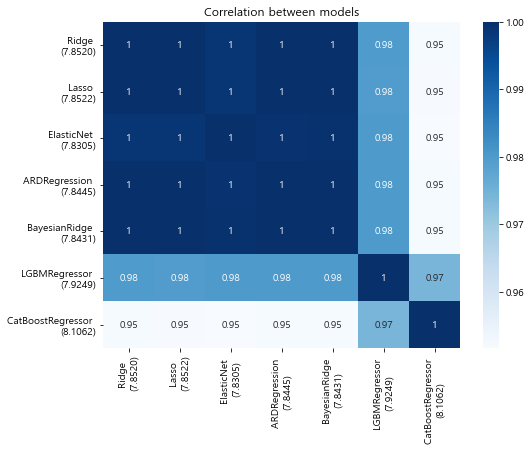

In [25]:
pred_results = []
for name, reg, reg_score in regs_trained:
    pred = list(reg.predict(r_dev))
    name = f'{name} \n({reg_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)
ensemble_results = ensemble_results.applymap(lambda x: float(x))

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

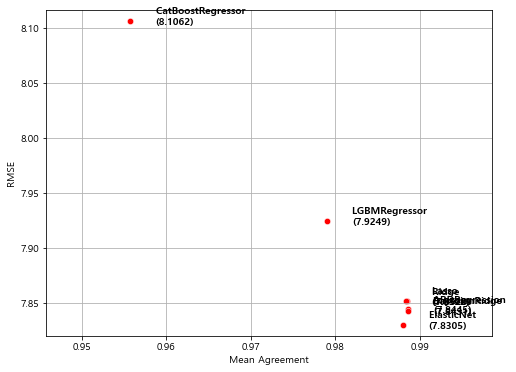

In [26]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
rmse = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'rmse': rmse, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="rmse", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.rmse[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.rmse.min()-0.01,df.rmse.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [27]:
selected = [#'LinearRegression',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            #'CatBoostRegressor',
            #'DeepNeuralNetwork'
            ]
models_for_ensemble = [(name,reg) for name,reg,score in regs_trained if name in selected]
mean_squared_error((models_for_ensemble[0][1].predict(r_dev)+models_for_ensemble[1][1].predict(r_dev))/2,y_dev2,squared=False)

7.8467753394863085

In [28]:
# 최적의 가중치 찾기 
selected = [#'LinearRegression',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            #'CatBoostRegressor',
            #'DeepNeuralNetwork'
            ]
models_for_ensemble = [(name,reg) for name,reg,score in regs_trained if name in selected]
weights_avg = []
rmse_best = 1000
for i in tqdm(range(1, 30, 1)):
    for j in range(1, 30, 1):
        if (i+j) != 30:
            continue
        pred = (models_for_ensemble[0][1].predict(r_dev).flatten() * i + models_for_ensemble[1][1].predict(r_dev) * j)/30
        rmse = np.sqrt(mean_squared_error(y_dev2, pred))
        if rmse < rmse_best:
            weights_avg = [i,j]
            rmse_best = rmse 
            print(rmse, i,j)            

print(rmse_best, weights_avg)

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 169.06it/s]

7.917770480604243 1 29
7.910936704906734 2 28
7.9043717181578295 3 27
7.898076190620483 4 26
7.892050767141515 5 25
7.886296066829591 6 24
7.8808126827443905 7 23
7.875601181597367 8 22
7.870662103464417 9 21
7.865995961510789 10 20
7.861603241728574 11 19
7.857484402687061 12 18
7.8536398752962775 13 17
7.85007006258397 14 16
7.846775339486309 15 15
7.8437560526525765 16 14
7.841012520264042 17 13
7.838545031867267 18 12
7.836353848222057 19 11
7.834439201164198 20 10
7.832801293483198 21 9
7.831440298815143 22 8
7.830356361550837 23 7
7.829549596759291 24 6
7.829020090126703 25 5
7.828767897910982 26 4
7.828767897910982 [26, 4]


In [32]:
w0,w1 = [26, 4]
selected = [#'LinearRegression',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            #'CatBoostRegressor',
            #'DeepNeuralNetwork'
            ]
models_for_ensemble = [(name,reg) for name,reg,score in regs_trained if name in selected]
avg = (models_for_ensemble[0][1].predict(r_dev).flatten() * w0 + models_for_ensemble[1][1].predict(r_dev) * w1)/(w0+w1)

### Deployment

In [44]:
w0,w1 = [26, 4]
selected = [#'LinearRegression',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            #'CatBoostRegressor',
            #'DeepNeuralNetwork'
            ]
models_for_ensemble = [(name,reg) for name,reg,score in regs_trained if name in selected]
avg_pred = (models_for_ensemble[0][1].predict(results_sub).flatten() * w0 + models_for_ensemble[1][1].predict(results_sub) * w1)/(w0+w1)
pd.DataFrame({'custid': test_id, 'age':avg_pred}).to_csv('results_ensemble_ela_lgbm.csv', index=False)